In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [ ]:
# import torch
# import numpy as np
# import pandas as pd

# def prepare_experimental_data(df):
#     """
#     Integrates double differential cross section over:
#     - Outgoing proton energy (E_sec) to get dsigma/dOmega
#     - Outgoing proton angle (theta) to get dsigma/dE

#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         Columns: E_inc, E_sec, theta, ddcs
        
#     Returns:
#     --------
#     tuple: (torch.Tensor, torch.Tensor, torch.Tensor)
#         - E_inc_unique: shape (n_inc,)
#         - dsigma_dOmega: shape (n_inc, n_theta)
#         - dsigma_dE: shape (n_inc, n_E_sec)
#     """

#     # Sort unique values
#     E_inc_unique = sorted(df['E_inc'].unique())
#     theta_unique = sorted(df['theta'].unique())
#     E_sec_unique = sorted(df['E_sec'].unique())

#     # Preallocate arrays
#     dsigma_dOmega = np.zeros((len(E_inc_unique), len(theta_unique)))
#     dsigma_dE = np.zeros((len(E_inc_unique), len(E_sec_unique)))

#     # Use bin widths for integration
#     theta_bin_width = np.diff(theta_unique).mean() if len(theta_unique) > 1 else 1.0
#     E_sec_bin_width = np.diff(E_sec_unique).mean() if len(E_sec_unique) > 1 else 1.0

#     # Compute dsigma/dOmega: integrate over E_sec
#     grouped_omega = df.groupby(['E_inc', 'theta'])['ddcs'].sum().reset_index()
#     for _, row in grouped_omega.iterrows():
#         e_idx = E_inc_unique.index(row['E_inc'])
#         theta_idx = theta_unique.index(row['theta'])
#         dsigma_dOmega[e_idx, theta_idx] = row['ddcs'] * E_sec_bin_width  # approximate integral

#     # Compute dsigma/dE: integrate over theta
#     grouped_E = df.groupby(['E_inc', 'E_sec'])['ddcs'].sum().reset_index()
#     for _, row in grouped_E.iterrows():
#         e_idx = E_inc_unique.index(row['E_inc'])
#         e_sec_idx = E_sec_unique.index(row['E_sec'])
#         dsigma_dE[e_idx, e_sec_idx] = row['ddcs'] * theta_bin_width  # approximate integral

#     return (
#         torch.tensor(E_inc_unique, dtype=torch.float32),
#         torch.tensor(dsigma_dOmega, dtype=torch.float32),
#         torch.tensor(dsigma_dE, dtype=torch.float32)
#     )


In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [ ]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

plot_integrated_cross_sections(integrated_results)

In [ ]:
# E_inc_unique, dsigma_dOmega, dsigma_dE = prepare_experimental_data(df)

# E_inc_unique, dsigma_dOmega, dsigma_dE

# dsigma_dOmega.size(), dsigma_dE.size()

# E_inc_unique

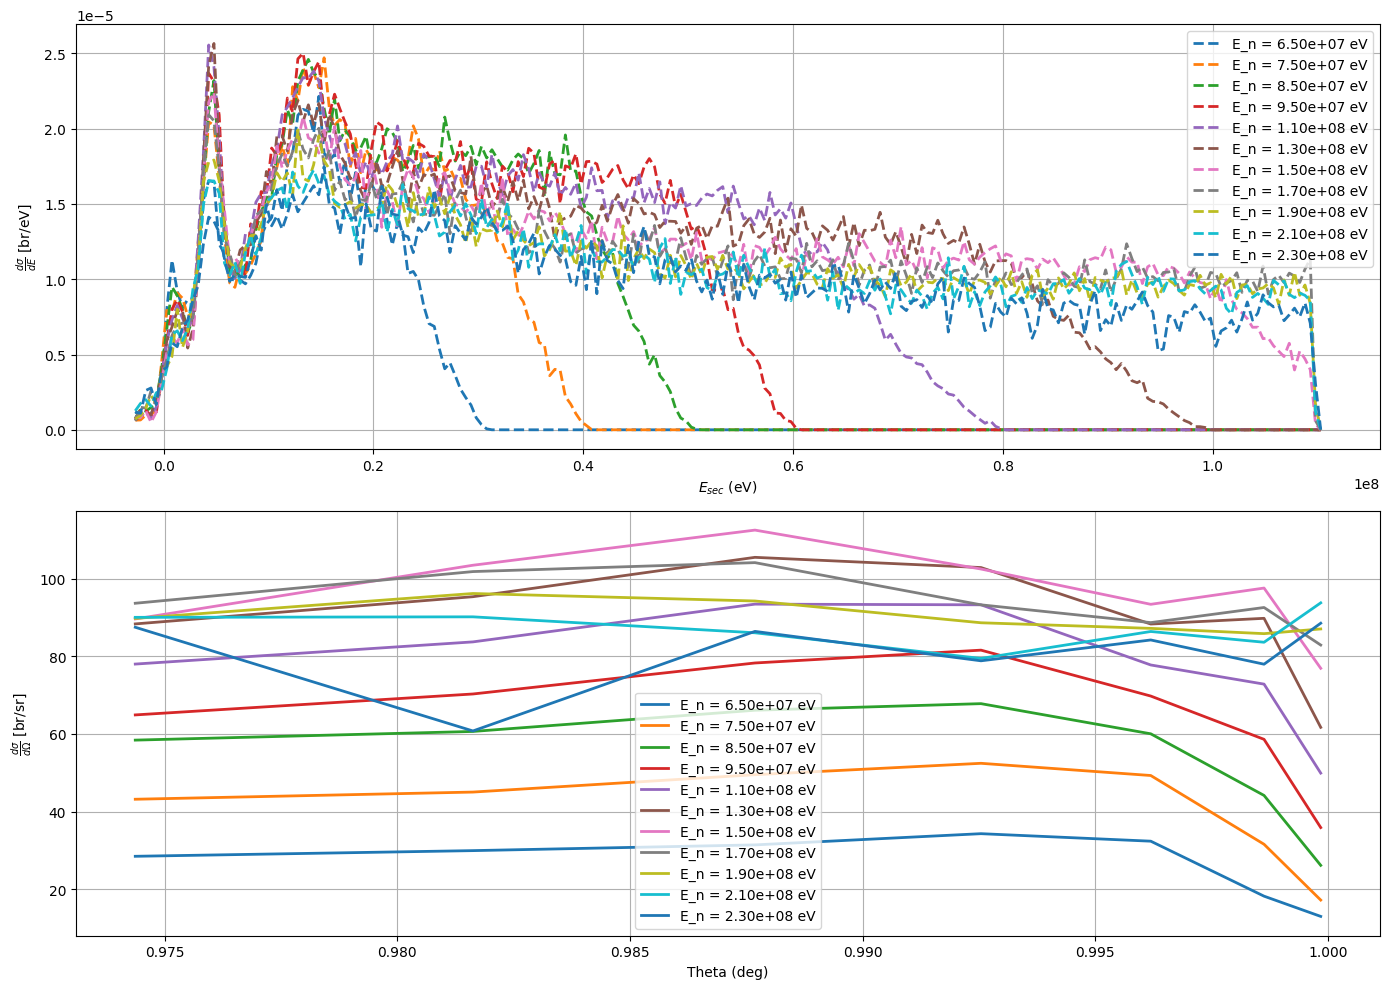

In [ ]:
# theta_values = sorted(df['theta'].unique())
# cos_theta = sorted(np.cos(np.radians(df['theta'].unique())))
# E_sec_unique = sorted(df['E_sec'].unique())



# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))

# for i in range(len(E_inc_unique)):    
#     ax1.plot(E_sec_unique, dsigma_dE[i], '--', label=f'E_n = {E_inc_unique[i]:.2e} eV', linewidth=2)
#     ax2.plot(cos_theta, dsigma_dOmega[i], '-', label=f'E_n = {E_inc_unique[i]:.2e} eV', linewidth=2)

# # ax1.set_title('Integrated DDCS over theta')
# # ax2.set_title('Integrated DDCS over E_sec')

# ax1.set_xlabel(r'$E_{sec}$ (eV)')
# ax1.set_ylabel(r'$\frac{d\sigma}{dE}$ [br/eV]')
# ax1.legend()
# ax1.grid(True)

# ax2.set_xlabel('Theta (deg)')
# ax2.set_ylabel(r'$\frac{d\sigma}{d\Omega}$ [br/sr]')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()

In [8]:
import torch
from torch import nn
import numpy as np

class NPReactionSimulator(nn.Module):
    def __init__(
        self,
        m_n=939.565,   # neutron mass [MeV/c^2]
        m_p=938.272,   # proton mass [MeV/c^2]
        M_A=29785.0,   # S-32 mass [MeV/c^2]
        S_n=7.70,      # neutron separation energy [MeV]
        S_p=13.46      # proton separation energy [MeV]
    ):
        super().__init__()
        # Store physical constants as buffers for device consistency
        self.register_buffer("m_n", torch.tensor(m_n))
        self.register_buffer("m_p", torch.tensor(m_p))
        self.register_buffer("M_A", torch.tensor(M_A))
        self.register_buffer("S_n", torch.tensor(S_n))
        self.register_buffer("S_p", torch.tensor(S_p))

    def forward(self, Ek, r1, r2, r3):
        """
        Inputs:
            Ek:  [B] neutron kinetic energy [MeV]
            r1:  [B] ∈ [0, 1] → proton energy fraction
            r2:  [B] ∈ [-1, 1] → cos(theta) direction
            r3:  [B] ∈ [-π, π] → phi direction
        Outputs:
            Ep_lab: [B] proton energy in lab frame [MeV]
            cos_theta_lab: [B] emission angle cosine in lab frame
        """
        m_n, m_p, M_A, S_n, S_p = self.m_n, self.m_p, self.M_A, self.S_n, self.S_p

        # Recoil kinetic energy
        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2 * m_n) / denom

        # Excitation energy and energy available
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        v_recoil = Tk / M_recoil
        beta = v_recoil
        gamma = 1.0 / torch.sqrt(1 - beta**2 + 1e-8)

        # Lorentz boost
        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)

        # Transverse momenta unchanged
        px_lab = px_com
        py_lab = py_com
        p_mag_lab = torch.sqrt(px_lab**2 + py_lab**2 + pz_lab**2 + 1e-8)

        Ep_lab = E_lab - m_p
        cos_theta_lab = pz_lab / (p_mag_lab + 1e-8)

        # Apply reaction validity mask
        Ep_lab = torch.where(mask, Ep_lab, torch.zeros_like(Ep_lab))
        cos_theta_lab = torch.where(mask, cos_theta_lab, torch.zeros_like(cos_theta_lab))

        return Ep_lab, cos_theta_lab


In [9]:
import torch
import torch.nn as nn
import math

class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        """
        Parameters:
        -----------
        x_eval : (M,) tensor
            Points at which to evaluate the KDE (fixed grid)
        bandwidth : float
            Bandwidth for the Gaussian kernel
        normalize : bool
            Whether to normalize the KDE to integrate to 1
        """
        super().__init__()
        self.register_buffer("x_eval", x_eval)
        self.bandwidth = bandwidth
        self.normalize = normalize
        # Register sqrt(2π) as buffer (so it's on the right device)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        x = self.x_eval[:, None]         # (M, 1)
        s = samples[None, :]             # (1, N)

        h = self.bandwidth
        diffs = (x - s) / h              # (M, N)
        kernel_vals = torch.exp(-0.5 * diffs**2) / (h * self.sqrt_2pi)

        if weights is None:
            weights = torch.ones_like(s)
        else:
            weights = weights[None, :]
            
        weighted = kernel_vals * weights  # (M, N)
        density = weighted.sum(dim=1) / (weights.sum() + 1e-12)

        if self.normalize:
            dx = self.x_eval[1] - self.x_eval[0]
            density = density / (density.sum() * dx + 1e-12)

        return density
    
    # def forward(self, samples):
    #     """
    #     Parameters:
    #     -----------
    #     samples : (N,) tensor
    #         Input samples to estimate KDE from
        
    #     Returns:
    #     --------
    #     density : (M,) tensor
    #         KDE evaluated at x_eval points
    #     """
    #     x = self.x_eval[:, None]         # (M, 1)
    #     s = samples[None, :]             # (1, N)

    #     # print("x_eval range:", self.x_eval.min().item(), self.x_eval.max().item())
    #     # print("x_sample range:", x.min().item(), x.max().item())

    #     h = self.bandwidth
    #     diffs = (x - s) / h              # (M, N)
    #     kernel_vals = torch.exp(-0.5 * diffs**2) / (h * self.sqrt_2pi)

    #     density = kernel_vals.mean(dim=1)  # (M,)

    #     if self.normalize:
    #         dx = self.x_eval[1] - self.x_eval[0]  # assume uniform spacing
    #         density = density / (density.sum() * dx + 1e-12)

    #     return density





In [10]:
import torch.nn as nn

class ECSPipeline(nn.Module):
    def __init__(self, E_eval):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=0.3)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = Ep_lab > 0
        Ep_lab = Ep_lab[valid]
        dsigma_dE = self.kde_E(Ep_lab)
        return dsigma_dE


class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=0.05)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        dsigma_dOmega = self.kde_theta(cos_theta_lab, weights=valid)
        return dsigma_dOmega
    
    # def forward(self, Ek, r1, r2, r3):
    #     Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)

    #     print("Ep_lab.requires_grad:", Ep_lab.requires_grad)
    #     print("cos_theta_lab.requires_grad:", cos_theta_lab.requires_grad)
    #     print("Ep_lab.grad_fn:", Ep_lab.grad_fn)
    #     print("cos_theta_lab.grad_fn:", cos_theta_lab.grad_fn)

    #     valid = Ep_lab > 0
    #     print("valid mask sum:", valid.sum().item())
        
    #     # Check if masking breaks grad
    #     masked_cos_theta = cos_theta_lab[valid]
    #     print("masked_cos_theta.requires_grad:", masked_cos_theta.requires_grad)
    #     print("masked_cos_theta.grad_fn:", masked_cos_theta.grad_fn)

    #     dsigma_dOmega = self.kde_theta(masked_cos_theta)

    #     print("dsigma_dOmega.requires_grad:", dsigma_dOmega.requires_grad)
    #     print("dsigma_dOmega.grad_fn:", dsigma_dOmega.grad_fn)

    #     return dsigma_dOmega



In [11]:
# import torch
# import numpy as np

# # Sample parameters
# B = 2000
# Ek = torch.full((B,), 65.0)
# uniform_samples = torch.rand((B, 3), device=device)  # uniform [0,1)

# r1 = uniform_samples[:, 0]                            # stays in [0, 1)
# r2 = uniform_samples[:, 1] * 2 - 1                    # maps [0,1) -> [-1, 1)
# r3 = uniform_samples[:, 2] * 2 * torch.pi - torch.pi  # maps [0,1) -> [-π, π)

# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32)
# E_sec_exp = E_sec_exp / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp)
# acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp)

# dsigma_dE_sim = ecs_pipeline(Ek, r1, r2, r3)            # shape matches len(E_sec_exp)
# dsigma_dOmega_sim = acs_pipeline(Ek, r1, r2, r3)        # shape matches len(cos_theta_exp)


In [12]:
# dsigma_dE_sim.size(), dsigma_dOmega_sim.size()

# dsigma_dE_sim
# dsigma_dOmega_sim


In [13]:
# # To match the exp data to the one just simulated

# # Pick the index of incident energy = 14 MeV
# e_idx = (E_inc == 14.0).nonzero(as_tuple=True)[0].item()

# # Get corresponding experimental vectors
# dsigma_dE_target = dsigma_dE_exp[e_idx]         # shape: (len(E_sec_exp),)
# dsigma_dOmega_target = dsigma_dOmega_exp[e_idx] # shape: (len(theta_exp),)

In [14]:
# import matplotlib.pyplot as plt

# # Plot energy spectrum
# plt.figure()
# plt.plot(E_sec_exp.numpy(), dsigma_dE_sim.detach().numpy())
# plt.xlabel("Proton Energy (MeV)")
# plt.ylabel("dσ/dE (arb. units)")
# plt.title("Differential Cross Section w.r.t Energy")
# plt.grid(True)

# # Plot angular distribution
# plt.figure()
# plt.plot(cos_theta_exp.numpy(), dsigma_dOmega_sim.detach().numpy())
# plt.xlabel("cos(θ_lab)")
# plt.ylabel("dσ/dΩ (arb. units)")
# plt.title("Differential Cross Section w.r.t Angle")
# plt.grid(True)

# plt.show()

In [15]:
import torch
import torch.nn.functional as F

# def kl_loss(simulated_ddcs, experimental_ddcs, eps=1e-12):
#     """
#     Compute KL divergence between simulated and experimental DDCS data.
#     Works for 1D (single sample) or 2D (batch x features) tensors.

#     Args:
#         simulated_ddcs: tensor [..., features]
#         experimental_ddcs: tensor [..., features]

#     Returns:
#         scalar KL divergence loss
#     """
#     # Normalize over last dimension
#     sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
#     exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

#     sim_dist = simulated_ddcs / sim_sum
#     exp_dist = experimental_ddcs / exp_sum

#     # Clamp to avoid log(0)
#     sim_dist = torch.clamp(sim_dist, min=eps)
#     exp_dist = torch.clamp(exp_dist, min=eps)

#     # KL divergence
#     kl = (exp_dist * (exp_dist.log() - sim_dist.log())).sum(dim=-1)

#     return kl.mean()

# def kl_loss(simulated_ddcs, experimental_ddcs, eps=1e-12):
#     # Normalize
#     sim_log_probs = torch.log_softmax(simulated_ddcs + eps, dim=-1)
#     exp_probs = torch.softmax(experimental_ddcs + eps, dim=-1)
#     return F.kl_div(sim_log_probs, exp_probs, reduction='batchmean')

import torch.nn.functional as F

def kl_loss_stable(simulated_ddcs, experimental_ddcs, eps=1e-8):
    # Normalize to distributions
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    # Clamp for numerical safety
    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    # Compute log probabilities
    log_sim = sim_dist.log()
    # log_exp = exp_dist.log()

    # Final KL divergence
    kl = F.kl_div(log_sim, exp_dist, reduction='batchmean', log_target=False)

    if torch.isnan(kl):
        print("KL loss is NaN")
        print("sim_dist:", sim_dist)
        print("exp_dist:", exp_dist)

    return kl




In [16]:
# # ------------------------------------------------------------------
# # Hyper-parameters
# # ------------------------------------------------------------------
# n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
# n_hidden    = 12      # number of hidden neurons in the network, at each layer
# n_layers    = 3       # number of hidden layers in the network
# n_out       = n_in    # must match the number of output parameters
# batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
# epochs      = 3   # number of epochs to train the network
# lr          = 1e-3    # learning rate for the optimizer

# # ------------------------------------------------------------------
# # MLP producing seeds in [0,1]^7
# # ------------------------------------------------------------------
# def make_mlp(n_in, n_hidden, n_layers, n_out):
#     layers, d = [], n_in
#     for _ in range(n_layers):
#         layers += [nn.Linear(d, n_hidden), nn.ReLU()]
#         d = n_hidden
#     layers += [nn.Linear(d, n_out), nn.Sigmoid()]
#     # layers += [nn.Linear(d, n_out), nn.Tanh()]
#     return nn.Sequential(*layers)

# net       = make_mlp(n_in, n_hidden, n_layers, n_out).to(device)
# optimiser = optim.Adam(net.parameters(), lr=lr)

# # ------------------------------------------------------------------

# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
epochs      = 10   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    # layers += [nn.Linear(d, n_out), nn.Tanh()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)
optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------
# Prep
# -------------

E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

# USAGE:
# debug_one_step(net, acs_pipeline, E_inc_val=E_inc_unique[0], batch_size=2000, n_in=n_in, device=device)



net.train()
for epoch in trange(epochs, desc="Training Epochs"):
    for i in range(len(integrated_results)):

        # Sample random inputs and feed to ML
        uniform_samples = torch.rand((batch_size, n_in), device=device)  # uniform [0,1)
        uniform_samples.requires_grad_(True)

        ######################NEW
        Ek = integrated_results[i]['E_inc'] / 1e6 # Sim code works in MeV (maybe I should have coded it in eV)
        # prepare axis for broadcasting
        Ek_expanded = Ek.expand(batch_size, 1)  # shape: [batch_size, 1]

        # Concatenate Ek with the uniform samples to create network input
        net_input = torch.cat([uniform_samples, Ek_expanded], dim=1).to(device)  # shape: [batch_size, 4]

        #DEBUG
        # print("Ek:", Ek)
        # print("Ek_expanded shape:", Ek_expanded.shape)
        # print("net_input shape:", net_input.shape)
        # print("Any NaN in net_input:", torch.isnan(net_input).any())

        t = net(net_input)  # Output shape: [batch_size, 3]
        #DEBUG
        # print("Network output t:", torch.isnan(t).any(), torch.isinf(t).any())

        ######################OLD

        # # Prepare neutron energy for this batch
        # Ek_val = E_inc_unique[i]  # scalar
        # Ek = torch.full((batch_size,), Ek_val, dtype=torch.float32).to(device)
        # t = net(uniform_samples)  # Output shape: [batch_size, 3]

        ######################

        r1 = t[:, 0]                            # in [0,1]
        r2 = t[:, 1] * 2 - 1                    # map [0,1] -> [-1,1]
        r3 = t[:, 2] * 2 * torch.pi - torch.pi  # map [0,1] -> [-π, π]



        if torch.isnan(Ek).any() or torch.isnan(r1).any():
            raise ValueError("NaNs in simulation inputs!")

        # dsigma_dE_sim = ecs_pipeline(Ek, r1, r2, r3)           
        dsigma_dOmega_sim = acs_pipeline(Ek, r1, r2, r3)  

        # dsigma_dOmega_exp = dsigma_dOmega[i].to(device)
        dsigma_dOmega_exp = integrated_results[i]['int_over_E_sec']

        assert dsigma_dOmega_sim.shape == dsigma_dOmega_exp.shape, f"Shape mismatch: sim {dsigma_dOmega_sim.shape}, exp {dsigma_dOmega_exp.shape}"
        
        #DEBUG
        # print("dsigma_dOmega_sim:", torch.isnan(dsigma_dOmega_sim).any(), torch.isinf(dsigma_dOmega_sim).any())
        # print("dsigma_dOmega_exp:", torch.isnan(dsigma_dOmega_exp).any(), torch.isinf(dsigma_dOmega_exp).any())


        loss = kl_loss_stable(dsigma_dOmega_sim, dsigma_dOmega_exp)

        #DEBUG
        # print("Loss:", loss.item())
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError("Loss contains NaN or Inf!")

        if torch.isnan(loss):
            raise ValueError("Loss is NaN — check KDE output or input simulation.")

        # Backprop
        optimiser.zero_grad()

        # loss.backward()
        # #DEBUG
        with torch.autograd.detect_anomaly():
            loss.backward(retain_graph=True)

        optimiser.step()
        
        #DEBUG
        for name, param in net.named_parameters():
            if param.grad is None:
                print(f"{name}: grad is None")
            else:
                print(f"{name}: grad mean = {param.grad.abs().mean().item():.6e}")

    print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\lucas\AppData\Local\Temp\ipykernel_22108\2058898922.py:101: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
Training Epochs:  10%|█         | 1/10 [00:00<00:01,  5.77it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad 

Training Epochs:  30%|███       | 3/10 [00:00<00:00,  8.57it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
Epoch   2 | Loss: 2.354471
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean =

Training Epochs:  50%|█████     | 5/10 [00:00<00:00,  9.76it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad 

Training Epochs:  70%|███████   | 7/10 [00:00<00:00,  8.67it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad 

Training Epochs:  80%|████████  | 8/10 [00:00<00:00,  8.29it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad 

Training Epochs: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]

0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad mean = 0.000000e+00
6.weight: grad mean = 0.000000e+00
6.bias: grad mean = 0.000000e+00
0.weight: grad mean = 0.000000e+00
0.bias: grad mean = 0.000000e+00
2.weight: grad mean = 0.000000e+00
2.bias: grad mean = 0.000000e+00
4.weight: grad mean = 0.000000e+00
4.bias: grad 

In [ ]:

# --- DEBUG STEP: insert this inside (or just before) your training loop to inspect gradient flow ---
import torch
import torch.nn.functional as F

def debug_one_step(net, acs_pipeline, E_inc_val=None, batch_size=2000, n_in=3, device='cpu'):
    net.train()
    device = next(net.parameters()).device if any(p.requires_grad for p in net.parameters()) else torch.device(device)
    
    # Network forward
    z = torch.rand(batch_size, n_in, device=device)
    t = net(z)
    print(">>> net output t: requires_grad:", t.requires_grad, " grad_fn:", t.grad_fn)
    
    try:
        r1 = t[:, 0].contiguous()
        r2 = t[:, 1].contiguous() * 2 - 1.0
        r3 = t[:, 2].contiguous() * 2 * torch.pi - torch.pi
    except Exception as e:
        print("Warning extracting r1,r2,r3:", e)
        r1 = torch.rand(batch_size, device=device)
        r2 = torch.rand(batch_size, device=device) * 2 - 1.0
        r3 = torch.rand(batch_size, device=device) * 2 * torch.pi - torch.pi

    if E_inc_val is None:
        E_inc_val = 65.0
    Ek = torch.full((batch_size,), float(E_inc_val), dtype=torch.float32, device=device)
    print("Ek.requires_grad:", Ek.requires_grad, "Ek.grad_fn:", Ek.grad_fn)

    # Try simulator call
    try:
        Ep_lab, cos_theta_lab = acs_pipeline.simulator(Ek, r1, r2, r3)
    except Exception as e:
        Ep_lab, cos_theta_lab = None, None
        print("Simulator call failed:", e)

    if Ep_lab is not None:
        print("Ep_lab.requires_grad:", Ep_lab.requires_grad, " grad_fn:", Ep_lab.grad_fn)
        print("cos_theta_lab.requires_grad:", cos_theta_lab.requires_grad, " grad_fn:", cos_theta_lab.grad_fn)
        valid_mask = (Ep_lab > 0).float()

        try:
            dsigma_dOmega = acs_pipeline.kde_theta(cos_theta_lab, weights=valid_mask)
        except TypeError:
            x = acs_pipeline.kde_theta.x_eval[:, None]
            s = cos_theta_lab[None, :]
            h = acs_pipeline.kde_theta.bandwidth
            diffs = (x - s) / h
            kernel_vals = torch.exp(-0.5 * diffs**2) / (h * acs_pipeline.kde_theta.sqrt_2pi)
            weighted = kernel_vals * valid_mask[None, :]
            dsigma_dOmega = weighted.sum(dim=1) / (valid_mask.sum() + 1e-12)
    else:
        try:
            dsigma_dOmega = acs_pipeline(Ek, r1, r2, r3)
        except Exception as e:
            print("Pipeline call failed:", e)
            return

    print("dsigma_dOmega.requires_grad:", dsigma_dOmega.requires_grad, " grad_fn:", dsigma_dOmega.grad_fn)

    # Dummy experimental target
    dsigma_exp = torch.zeros_like(dsigma_dOmega, device=device)

    # Loss
    loss = F.mse_loss(dsigma_dOmega, dsigma_exp)
    print("loss grad_fn:", loss.grad_fn)

    # Check grad w.r.t. net output
    grad_wrt_t = torch.autograd.grad(loss, t, retain_graph=True, allow_unused=True)
    print("grad(loss, t):", grad_wrt_t)

    try:
        optimiser.zero_grad()
    except Exception:
        pass

    with torch.autograd.detect_anomaly():
        loss.backward(retain_graph=True)

    # Parameter grads
    for name, p in net.named_parameters():
        print("param", name, " grad is None?", p.grad is None,
              " mean abs grad:", None if p.grad is None else p.grad.abs().mean().item())

    try:
        optimiser.zero_grad()
    except Exception:
        pass

debug_one_step(net, acs_pipeline, E_inc_val=E_inc_unique[0], batch_size=2000, n_in=n_in, device=device)

>>> net output t: requires_grad: True  grad_fn: <SigmoidBackward0 object at 0x000002548470AC80>
Ek.requires_grad: False Ek.grad_fn: None
Ep_lab.requires_grad: True  grad_fn: <WhereBackward0 object at 0x000002548470A8C0>
cos_theta_lab.requires_grad: True  grad_fn: <WhereBackward0 object at 0x000002548470A8C0>
dsigma_dOmega.requires_grad: True  grad_fn: <DivBackward0 object at 0x000002548470AC80>
loss grad_fn: <MseLossBackward0 object at 0x000002548470AC80>
grad(loss, t): (tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),)
param 0.weight  grad is None? False  mean abs grad: 0.0
param 0.bias  grad is None? False  mean abs grad: 0.0
param 2.weight  grad is None? False  mean abs grad: 0.0
param 2.bias  grad is None? False  mean abs grad: 0.0
param 4.weight  grad is None? False  mean abs grad: 0.0
param 4.bias  grad is None? False  mean abs grad: 0.0
param 6.weight  grad is None? False  mean abs 

C:\Users\lucas\AppData\Local\Temp\ipykernel_12020\53676074.py:99: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
